In [2]:
import pandas as pd
import numpy as np
import string
import scipy as sp
from math import ceil
import seaborn as sns
from glob import glob
from Bio import pairwise2, SeqIO, Seq
import ternary
from matplotlib_venn import venn2_unweighted, venn3, venn3_circles, venn3_unweighted
import gffpandas.gffpandas as gffpd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import copy
import pycircos
from Bio.SeqUtils import GC
import textwrap
import math
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

sns.set_context(rc = {'legend.fontsize': 8, 'ytick.labelsize': 8, 'xtick.labelsize':8, 'axes.labelsize':8})
matplotlib.rcParams["font.family"] = "Arial"
OUT_DIR = '../../02-OUTPUT/06-ANALYSIS'

primary = '#33B9CB'
secondary = '#6A994E'
tertiary = '#F5911F'

def parse_tss(in_path,bv1_folder,bv2_folder,bv3_folder):
    def classify_TSS(row):
        if row['Primary'] == 1:
            return 'primary'
        elif row['Secondary'] == 1:
            return 'secondary'
        elif row['Internal'] == 1:
            return 'internal'
        elif row['Antisense'] == 1:
            return 'antisense'
        elif row['Locus_tag'] == 'orphan':
            return 'orphan'
        else:
            raise Exception('error?!', row)

    bv1_df = None
    for file in glob(f'{in_path}/{bv1_folder}/output/TSSs/MasterTables/*/MasterTable.tsv'):
        tmp_df = pd.read_csv(file,sep='\t')
        bv1_df = pd.concat([bv1_df,tmp_df])
    bv1_df = bv1_df.reset_index(drop=True)
    bv1_df['biovar'] = 'BV1'

    bv2_df = None
    for file in glob(f'{in_path}/{bv2_folder}/output/TSSs/MasterTables/*/MasterTable.tsv'):
        tmp_df = pd.read_csv(file,sep='\t')
        bv2_df = pd.concat([bv2_df,tmp_df])
    bv2_df = bv2_df.reset_index(drop=True)
    bv2_df['biovar'] = 'BV2'

    bv3_df = None
    for file in glob(f'{in_path}/{bv3_folder}/output/TSSs/MasterTables/*/MasterTable.tsv'):
        tmp_df = pd.read_csv(file,sep='\t')
        bv3_df = pd.concat([bv3_df,tmp_df])
    bv3_df = bv3_df.reset_index(drop=True)
    bv3_df['biovar'] = 'BV3'

    tss_df = pd.concat([bv1_df,bv2_df,bv3_df]).reset_index(drop=True)
    tss_df['biovar'] = tss_df['biovar'].astype(str)

    tss_df['TSS_class'] = tss_df.apply(lambda row: classify_TSS(row),axis=1)
    tss_df['contig'] = tss_df['contigID'].apply(lambda x: x.split('|')[0])

    del bv1_df, bv2_df, bv3_df, tmp_df

    conditions = tss_df.groupby(['biovar','contig','SuperPos','SuperStrand']).agg( {'Genome': lambda x: x.tolist() }).reset_index().rename(columns={'Genome':'conditions'})

    tss_df = tss_df.drop(columns='Genome')
    tss_df = tss_df.drop_duplicates()
    tss_df = tss_df.drop_duplicates(subset=['biovar','contig','SuperPos','SuperStrand'])
    tss_df = tss_df.merge( conditions, on=['biovar','contig','SuperPos','SuperStrand'])

    return tss_df

In [3]:
# optimized_df = parse_tss(in_path="../../02-OUTPUT/04-TSS/",bv1_folder="BV1-optimized",bv2_folder="BV2-optimized",bv3_folder="BV3-optimized")
# optimized_df['dataset'] = 'optimized'
# optimized_df.to_csv(f'{OUT_DIR}/optimized_tss.csv',index=False)

# default_df = parse_tss(in_path="../../02-OUTPUT/04-TSS/",bv1_folder="BV1-raw",bv2_folder="BV2-raw",bv3_folder="BV3-raw")
# default_df['dataset'] = 'default'
# default_df.to_csv(f'{OUT_DIR}/default_tss.csv',index=False)

# tss_df = pd.concat([optimized_df, default_df]).reset_index(drop=True)
# tss_df['TSS_class'] = tss_df['TSS_class'].astype('category')
# tss_df['TSS_class'] = tss_df['TSS_class'].cat.set_categories(['primary', 'secondary', 'internal', 'antisense', 'orphan', ], ordered=True)
# tss_df = tss_df[['biovar','contig','SuperPos', 'SuperStrand','Locus_tag','TSS_class','Sequence -50 nt upstream + TSS (51nt)','UTRlength','GeneLength','Putative sRNA','Putative asRNA','dataset']]
# tss_df = tss_df.rename(columns={
#     'SuperPos':'TSS_position',
#     'SuperStrand':'TSS_strand',
#     'Locus_tag':'TSS_locus_tag',
#     'UTRlength':'UTR_length',
#     'GeneLength':'gene_length',
#     'Putative sRNA':'putative_sRNA',
#     'Putative asRNA':'putative_asRNA',
#     'Sequence -50 nt upstream + TSS (51nt)':'TSS_promoter',
#     })
# tss_df.to_csv(f'{OUT_DIR}/tss_df.csv',index=False)

optimized_df = pd.read_csv(f'{OUT_DIR}/tss_df.csv').query('dataset == "optimized"')
tss_bases = optimized_df.query("TSS_class == 'primary'")['TSS_promoter'].apply(lambda x: x[-1])
tss_bases.value_counts()

A    2294
G    1943
T     205
C     148
Name: TSS_promoter, dtype: int64

Figure 3: General transcriptomic features of the three main lineages of agrobacteria

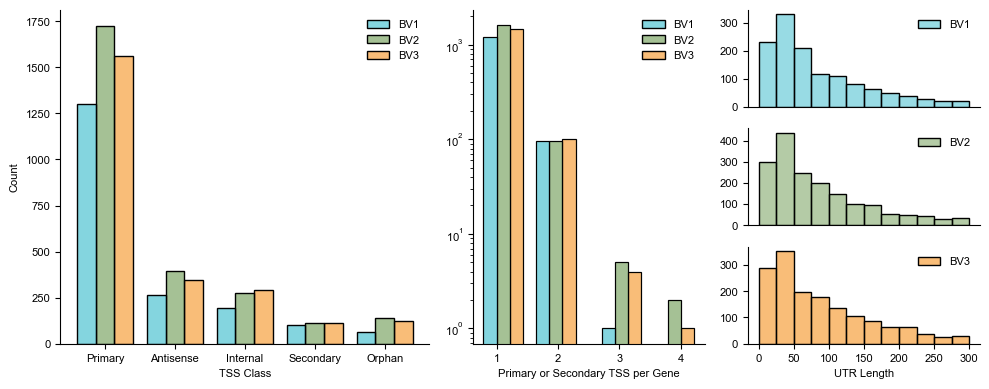

In [4]:
fig = plt.figure(tight_layout=True,figsize=(10,4))
gs = gridspec.GridSpec(3,14)

optimized_df['TSS_class'] = optimized_df['TSS_class'].apply(lambda x: x.capitalize())
optimized_df['dataset'] = optimized_df['dataset'].apply(lambda x: x.capitalize())

g = sns.histplot(data=optimized_df,x='TSS_class',hue='biovar',multiple='dodge',shrink=0.8,alpha=0.6,palette=[primary,secondary,tertiary],ax=fig.add_subplot(gs[0:3, 0:6]))
plt.xlabel('TSS Class')
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
sns.despine()

tmp = optimized_df.query('TSS_class == "Primary" or TSS_class == "Secondary"').drop_duplicates(subset=['contig','TSS_position','TSS_strand']).groupby(['biovar','TSS_locus_tag']).count().reset_index()
g = sns.histplot(data=tmp,x='TSS_position',hue='biovar',multiple='dodge',shrink=3,alpha=0.6,palette=[primary,secondary,tertiary],ax=fig.add_subplot(gs[0:3, 6:10]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_yscale('log')
g.set_ylabel(None)
g.set_xticks(range(1,5))
g.set_xlabel('Primary or Secondary TSS per Gene')
sns.despine()

g = sns.histplot(data=optimized_df.query('TSS_class == "Primary" and biovar =="BV1"'),x='UTR_length',hue='biovar',multiple='dodge',alpha=0.5,palette=[primary],bins=list(range(0,325,25)),ax=fig.add_subplot(gs[0, 10:15]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_xticklabels([])
g.tick_params(bottom=False)
g.yaxis.set_major_locator(ticker.MultipleLocator(100))
g.set_ylabel(None)
g.set_xlabel(None)
sns.despine()
g = sns.histplot(data=optimized_df.query('TSS_class == "Primary" and biovar =="BV2"'),x='UTR_length',hue='biovar',multiple='dodge',alpha=0.5,palette=[secondary],bins=list(range(0,325,25)),ax=fig.add_subplot(gs[1, 10:15]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_xticklabels([])
g.tick_params(bottom=False)
g.set_ylabel(None)
g.set_xlabel(None)
g.yaxis.set_major_locator(ticker.MultipleLocator(100))
sns.despine()
g = sns.histplot(data=optimized_df.query('TSS_class == "Primary" and biovar =="BV3"'),x='UTR_length',hue='biovar',multiple='dodge',alpha=0.6,palette=[tertiary],bins=list(range(0,325,25)),ax=fig.add_subplot(gs[2, 10:15]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.yaxis.set_major_locator(ticker.MultipleLocator(100))
g.xaxis.set_major_locator(ticker.MultipleLocator(50))
g.set_ylabel(None)
g.set_xlabel('UTR Length')
sns.despine()

fig.savefig(f'{OUT_DIR}/fig3.png',dpi=300,transparent=True,bbox_inches='tight')


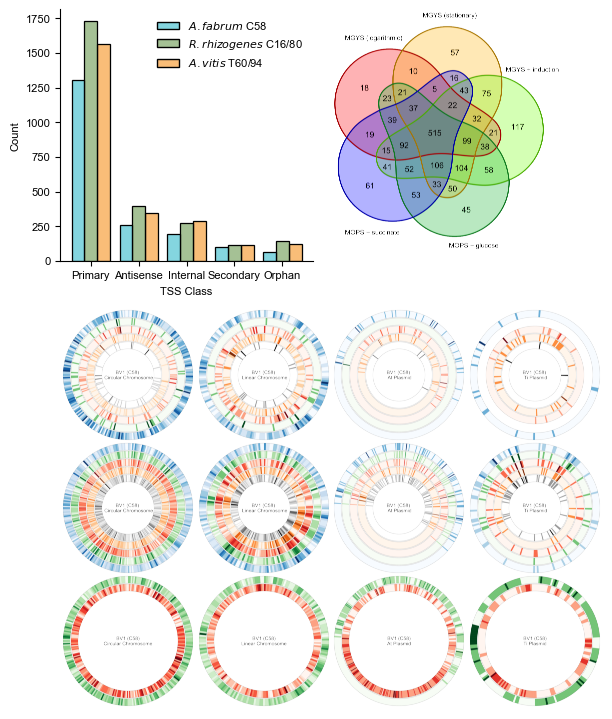

In [5]:
fig = plt.figure(figsize=(7,9.5))
gs1 = gridspec.GridSpec(10,13,wspace=-0.1,hspace=-0.4)
gs2 = gridspec.GridSpec(10,12,wspace=0.0,hspace=-0.5)

tmp = optimized_df.copy()
tmp['biovar'] = tmp['biovar'].map({'BV1':r'$\it{A. fabrum}$ C58','BV2':r'$\it{R. rhizogenes}$ C16/80','BV3':r'$\it{A. vitis}$ T60/94'})
g = sns.histplot(data=tmp,x='TSS_class',hue='biovar',multiple='dodge',shrink=0.8,alpha=0.6,palette=[primary,secondary,tertiary],ax=fig.add_subplot(gs1[0:3, 0:6]))
plt.xlabel('TSS Class')
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
sns.despine()

ax = fig.add_subplot(gs1[0:3, 5:])
ax.imshow(plt.imread(f'{OUT_DIR}/BV1_venn_all.png')[550:-550,550:-550])
ax.axis('off')

CROP = 100
ax = fig.add_subplot(gs2[4:6, 0:3])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[4:6, 3:6])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[4:6, 6:9])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[4:6, 9:12])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[6:8, 0:3])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[6:8, 3:6])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[6:8, 6:9])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[6:8, 9:12])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[8:, 0:3])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[8:, 3:6])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[8:, 6:9])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs2[8:, 9:12])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

fig.savefig(f'{OUT_DIR}/04-fig3.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

<Figure size 1500x200 with 0 Axes>

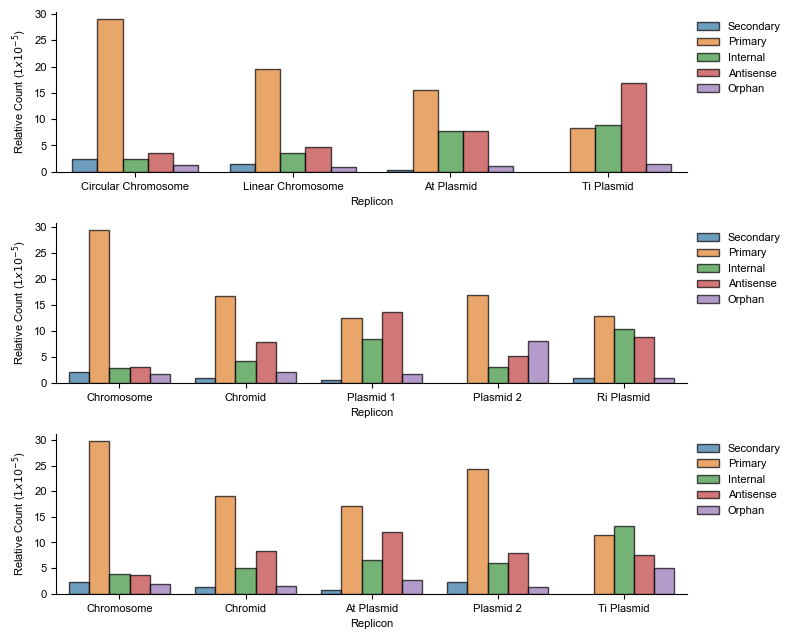

In [6]:
fna_df = pd.read_csv('../../02-OUTPUT/06-ANALYSIS/table1.csv').rename(columns={'name':'contig'})
fna_df.loc[2,'sequence_len'] = fna_df.loc[2,'sequence_len'] - 194434
test = optimized_df.groupby(['biovar','contig','TSS_class']).count().query('TSS_position > 0').reset_index()[['biovar','contig','TSS_class','TSS_position']]
test = test.merge(fna_df,on=['contig','biovar'])
test['TSS_class'] = test['TSS_class'].astype('category')
test['TSS_class'] = test['TSS_class'].cat.set_categories(['Secondary', 'Primary', 'Internal', 'Antisense', 'Orphan' ], ordered=True)
test['rel_count'] = test['TSS_position'] / test['sequence_len']
test['rel_count'] = test['rel_count'] * 1E05
test['biovar-contig'] = test['biovar'] + '-' + test['contig']
plt.figure(figsize=(15,2))
test['contig'] = test['contig'].replace({"NC_003062.2":"Circular Chromosome","NC_003063.2":"Linear Chromosome","NC_003064.2":"At Plasmid","NC_003065.3":"Ti Plasmid"})
test['contig'] = test['contig'].replace({'chromid':'Chromid', 'chromosome':'Chromosome', 'pTi':'Ti Plasmid', 'plasmid1':'Plasmid 1','plasmid2':'Plasmid 2', 'pAt':'At Plasmid'})


fig = plt.figure(tight_layout=True,figsize=(8,6.5))
gs = gridspec.GridSpec(3,1)

ax = fig.add_subplot(gs[0, 0])
g = sns.barplot(data=test[~test['contig'].isin([str(x) for x in range(1,15)])].query('biovar == "BV1"'),x='contig',y='rel_count',hue='TSS_class',ax=ax,hue_order=['Secondary', 'Primary', 'Internal', 'Antisense', 'Orphan'],edgecolor="black",linewidth=1.0,alpha=0.7)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_ylabel('Relative Count ($1 x 10^{-5}$)')
g.set_xlabel('Replicon')
sns.despine()

ax = fig.add_subplot(gs[1, 0])
tmp = test[~test['contig'].isin([str(x) for x in range(1,15)])].query('biovar == "BV2"').copy()
tmp['contig'] = tmp['contig'].replace({'Ti Plasmid':'Ri Plasmid'})
g = sns.barplot(data=tmp,x='contig',y='rel_count',hue='TSS_class',ax=ax,order=['Chromosome','Chromid','Plasmid 1','Plasmid 2','Ri Plasmid'],hue_order=['Secondary', 'Primary', 'Internal', 'Antisense', 'Orphan'],edgecolor="black",linewidth=1.0,alpha=0.7)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_ylabel('Relative Count ($1 x 10^{-5}$)')
g.set_xlabel('Replicon')
sns.despine()

ax = fig.add_subplot(gs[2, 0])
g = sns.barplot(data=test[~test['contig'].isin([str(x) for x in range(1,15)])].query('biovar == "BV3"'),x='contig',y='rel_count',hue='TSS_class',ax=ax,order=['Chromosome','Chromid','At Plasmid','Plasmid 2','Ti Plasmid'],hue_order=['Secondary', 'Primary', 'Internal', 'Antisense', 'Orphan'],edgecolor="black",linewidth=1.0,alpha=0.7)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_ylabel('Relative Count ($1 x 10^{-5}$)')
g.set_xlabel('Replicon')
sns.despine()

fig.savefig(f'{OUT_DIR}/04-rel_counts.png',dpi=600,bbox_inches='tight',transparent=True)
plt.show()

In [9]:
sns.barplot(data=test[~test['contig'].isin([str(x) for x in range(1,15)])].query('biovar == "BV3"'),x='contig',y='rel_count',hue='TSS_class',ax=ax,order=['Chromosome','Chromid','At Plasmid','Plasmid 2','Ti Plasmid'],hue_order=['Secondary', 'Primary', 'Internal', 'Antisense', 'Orphan'],edgecolor="black",linewidth=1.0,alpha=0.7)
plt.show()

<AxesSubplot: xlabel='contig', ylabel='rel_count'>

In [7]:
# plt.figure(figsize=(6,6))
# g = sns.displot(data=tss_df.query('group == "Optimized" and TSS_class == "Primary"'),x='UTRlength',hue='biovar',multiple='dodge',palette=[primary,secondary,tertiary],kde=True,aspect=1.3,bins=list(range(0,325,25)))
# # g = sns.displot(kind='kde',data=tss_df.query('group == "optimized" and TSS_class == "primary"'),x='UTRlength',hue='biovar',multiple='stack',palette=[blue,green,orange],aspect=1.3,height=4)
# plt.xlabel('UTR Length')
# g.legend.set_title(None)
# g.savefig('{OUT_DIR}/fig3c.png',dpi=300,bbox_inches='tight',transparent=True)
# plt.show()

In [8]:
# with open('{OUT_DIR}/bv1_unique_primary_promoters.fna','w') as file:
#     for idx, row in promoter_df.query('biovar == "BV1" and TSS_class == "primary"').iterrows():
#         file.write(f'>{row["contig"]}|{row["SuperPos"]}|{row["SuperStrand"]}\n{row["Sequence -50 nt upstream + TSS (51nt)"]}\n')

# with open('{OUT_DIR}/bv2_unique_primary_promoters.fna','w') as file:
#     for idx, row in promoter_df.query('biovar == "BV2" and TSS_class == "primary"').iterrows():
#         file.write(f'>{row["contig"]}|{row["SuperPos"]}|{row["SuperStrand"]}\n{row["Sequence -50 nt upstream + TSS (51nt)"]}\n')

# with open('{OUT_DIR}/bv3_unique_primary_promoters.fna','w') as file:
#     for idx, row in promoter_df.query('biovar == "BV3" and TSS_class == "primary"').iterrows():
#         file.write(f'>{row["contig"]}|{row["SuperPos"]}|{row["SuperStrand"]}\n{row["Sequence -50 nt upstream + TSS (51nt)"]}\n')

# examples where there is secondary, antisense, or internal but no primary TSS

In [9]:
class_df = optimized_df.groupby('TSS_locus_tag').agg( {'TSS_class': lambda x: set(x.tolist()) }).drop('orphan').reset_index()
class_df['has_primary'] = class_df['TSS_class'].apply(lambda x: 'Primary' in x)
class_df.query('has_primary == False').TSS_class.value_counts()
# class_df.to_csv(f'{OUT_DIR}/optimized_tss_no_primary.csv',index=False)

{Antisense}              684
{Internal}               508
{Internal, Antisense}     69
Name: TSS_class, dtype: int64